In [1]:
import random

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw

In [3]:
import torch
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.utils import to_undirected, to_networkx
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
import matplotlib.colors as mcolors

In [5]:
from ogb.utils.features import (allowable_features, atom_to_feature_vector,
 bond_to_feature_vector, atom_feature_vector_to_dict, bond_feature_vector_to_dict) 
import numpy as np


In [6]:


def ReorderCanonicalRankAtoms(mol):
    order = tuple(zip(*sorted([(j, i) for i, j in enumerate(Chem.CanonicalRankAtoms(mol))])))[1]
    mol_renum = Chem.RenumberAtoms(mol, order)
    return mol_renum, order

def smiles2graph(smiles_string, removeHs=True, reorder_atoms=False):
    """
    Converts SMILES string to graph Data object
    :input: SMILES string (str)
    :return: graph object
    """

    mol = Chem.MolFromSmiles(smiles_string)
    mol = mol if removeHs else Chem.AddHs(mol)
    if reorder_atoms:
        mol, _ = ReorderCanonicalRankAtoms(mol)

    # atoms
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_to_feature_vector(atom))
    x = np.array(atom_features_list, dtype = np.int64)

    # bonds
    num_bond_features = 3  # bond type, bond stereo, is_conjugated
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # add edges in both directions
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = np.array(edges_list, dtype = np.int64).T

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = np.array(edge_features_list, dtype = np.int64)

    else:   # mol has no bonds
        edge_index = np.empty((2, 0), dtype = np.int64)
        edge_attr = np.empty((0, num_bond_features), dtype = np.int64)

    graph = dict()
    graph['edge_index'] = edge_index
    graph['edge_feat'] = edge_attr
    graph['node_feat'] = x
    graph['num_nodes'] = len(x)

    return graph 


if __name__ == '__main__':
    graph = smiles2graph('O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5')
    print(graph)

{'edge_index': array([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  3,  6,  6,  7,  7,  8,
         8,  9,  9, 10, 10, 11,  9, 12, 12, 13, 13, 14, 14, 15, 15, 16,
        15, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22,  4,  0,  7,  5,
        13,  6, 18, 12, 21, 17],
       [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  3,  7,  6,  8,  7,
         9,  8, 10,  9, 11, 10, 12,  9, 13, 12, 14, 13, 15, 14, 16, 15,
        17, 15, 18, 17, 19, 18, 20, 19, 21, 20, 22, 21,  0,  4,  5,  7,
         6, 13, 12, 18, 17, 21]]), 'edge_feat': array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
    

/home/hai/miniconda3/envs/graph/lib/python3.11/site-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torc

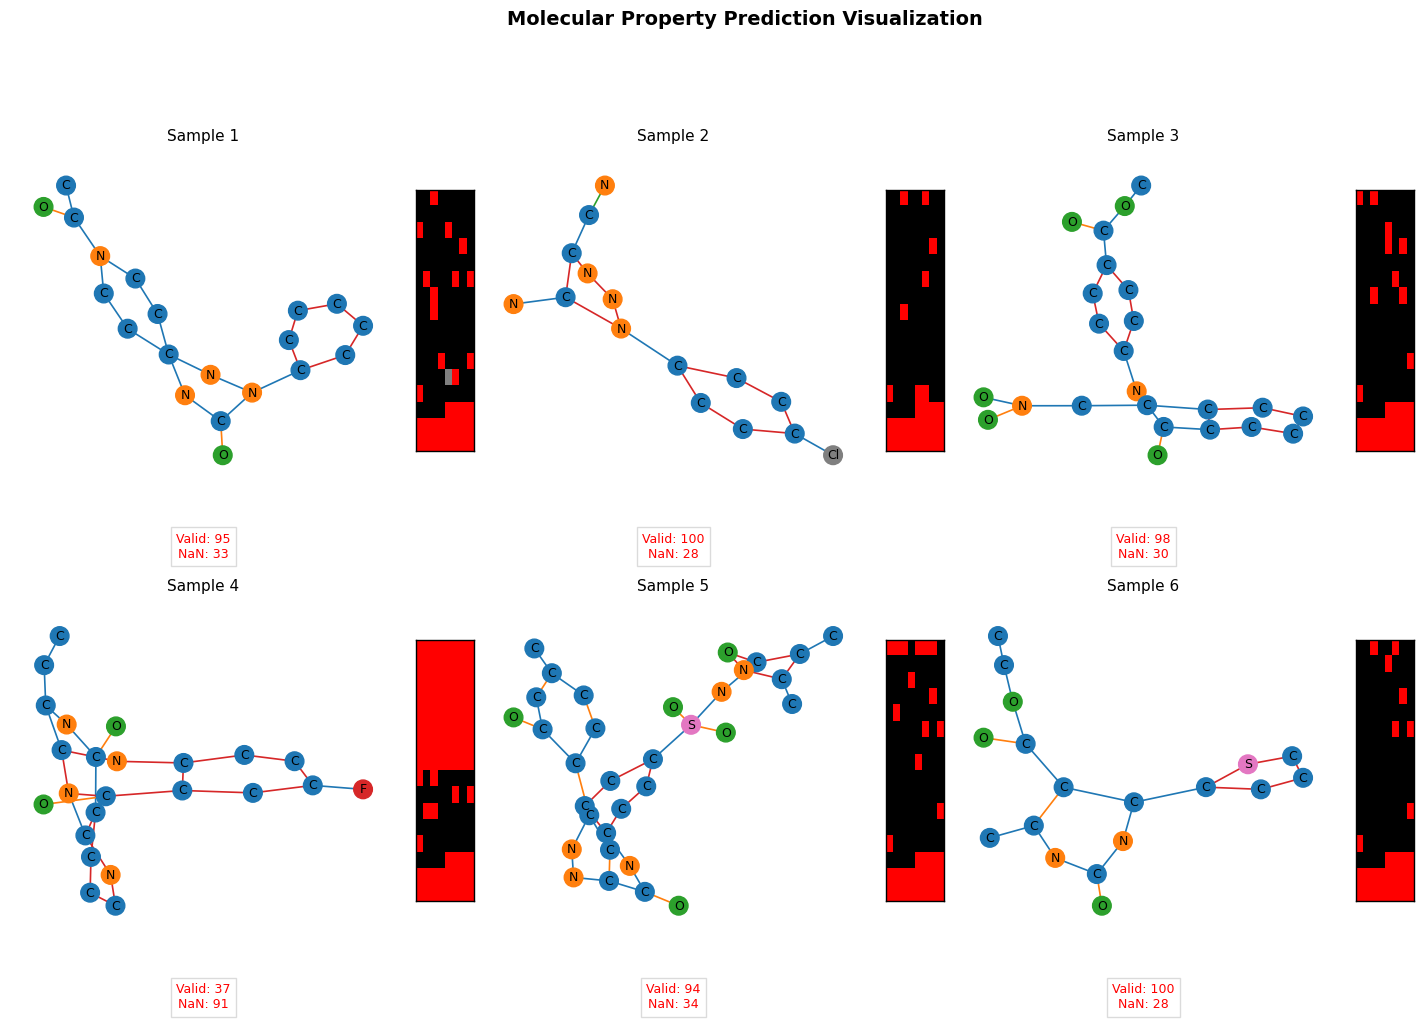

In [7]:

# Configuration remains the same
atomic_numbers_to_elements = {
    6: 'C', 7: 'N', 8: 'O', 9: 'F', 14: 'Si',
    15: 'P', 16: 'S', 17: 'Cl', 35: 'Br',
}
elements_to_colors = {
    element: f'C{index}'
    for index, element in enumerate(atomic_numbers_to_elements.values())
}
elements_to_colors['?'] = 'C0'

bond_types_to_colors = {num: f'C{num}' for num in range(4)}

plt.rcParams['font.family'] = 'DejaVu Sans'

# Node/Edge style functions remain the same
def node_color_fn(graph):
    atomic_numbers = 1 + graph.x[:, 0].numpy()
    return {
        index: elements_to_colors[atomic_numbers_to_elements.get(atomic_number, '?')]
        for index, atomic_number in enumerate(atomic_numbers)
    }

def node_label_fn(graph):
    atomic_numbers = 1 + graph.x[:, 0].numpy()
    return {
        index: atomic_numbers_to_elements.get(atomic_number, '?')
        for index, atomic_number in enumerate(atomic_numbers)
    }

def edge_color_fn(graph):
    bonds = graph.edge_index.numpy().T
    bond_types = graph.edge_attr[:, 0].numpy()
    return {
        tuple(bond): bond_types_to_colors[bond_type]
        for bond, bond_type in zip(bonds, bond_types)
    }

def create_label_rectangle(labels):
    # Create a 3D array for RGB colors
    rectangle = np.zeros((16, 8, 3))
    
    # Define colors: black (0,0,0), gray (0.5,0.5,0.5), red (1,0,0)
    black = np.array([0, 0, 0])
    gray = np.array([0.5, 0.5, 0.5])
    red = np.array([1, 0, 0])
    
    for i, label in enumerate(labels):
        row, col = divmod(i, 8)
        if np.isnan(label):
            rectangle[row, col] = red
        elif label == 1:
            rectangle[row, col] = gray
        else:  # label == 0
            rectangle[row, col] = black
    
    return rectangle

def visualize_examples(dataset):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Molecular Property Prediction Visualization', 
                 fontsize=14, y=1.02, fontweight='bold')
    axs = axs.flatten()

    for i in range(6):
        graph = dataset[i]
        G = to_networkx(graph, to_undirected=True)
        ax = axs[i]
        
        # Create main subplot for molecule
        pos = nx.spring_layout(G, seed=42, k=0.25)
        nx.draw(G, pos,
                node_color=[node_color_fn(graph)[node] for node in G.nodes()],
                labels=node_label_fn(graph),
                edge_color=[edge_color_fn(graph)[tuple(edge)] for edge in G.edges()],
                with_labels=True,
                node_size=180,
                font_size=9,
                width=1.2,
                ax=ax)

        # Calculate label statistics
        y = graph.y.numpy().flatten()
        valid_labels = np.sum(~np.isnan(y))
        nan_count = np.sum(np.isnan(y))

        # Create and position the rectangle
        rectangle = create_label_rectangle(y)
        
        # Create inset axes for the rectangle
        rect_ax = ax.inset_axes([1.05, 0.1, 0.15, 0.8])  # [x, y, width, height]
        
        # Display rectangle with border
        rect_ax.imshow(rectangle, aspect='auto', interpolation='nearest')
        
        # Add border around the entire rectangle
        rect_ax.spines['top'].set_visible(True)
        rect_ax.spines['bottom'].set_visible(True)
        rect_ax.spines['left'].set_visible(True)
        rect_ax.spines['right'].set_visible(True)
        rect_ax.spines['top'].set_color('black')
        rect_ax.spines['bottom'].set_color('black')
        rect_ax.spines['left'].set_color('black')
        rect_ax.spines['right'].set_color('black')
        rect_ax.spines['top'].set_linewidth(1)
        rect_ax.spines['bottom'].set_linewidth(1)
        rect_ax.spines['left'].set_linewidth(1)
        rect_ax.spines['right'].set_linewidth(1)
        
        # Remove ticks but keep the border
        rect_ax.set_xticks([])
        rect_ax.set_yticks([])

        # Add title and statistics
        ax.set_title(f"Sample {i+1}", fontsize=11, pad=12)
        ax.text(0.5, -0.15, f"Valid: {valid_labels}\nNaN: {nan_count}",
                ha='center', va='top',
                transform=ax.transAxes,
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray'),
                color='red' if nan_count > 0 else 'green')

    # Hide empty subplot
    axs[-1].axis('off')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.savefig('samples.png')

# Load and visualize
dataset = PygGraphPropPredDataset(name='ogbg-molpcba')
visualize_examples(dataset)

/home/hai/miniconda3/envs/graph/lib/python3.11/site-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torc

Found 25 regular graph(s) in first 437929 samples


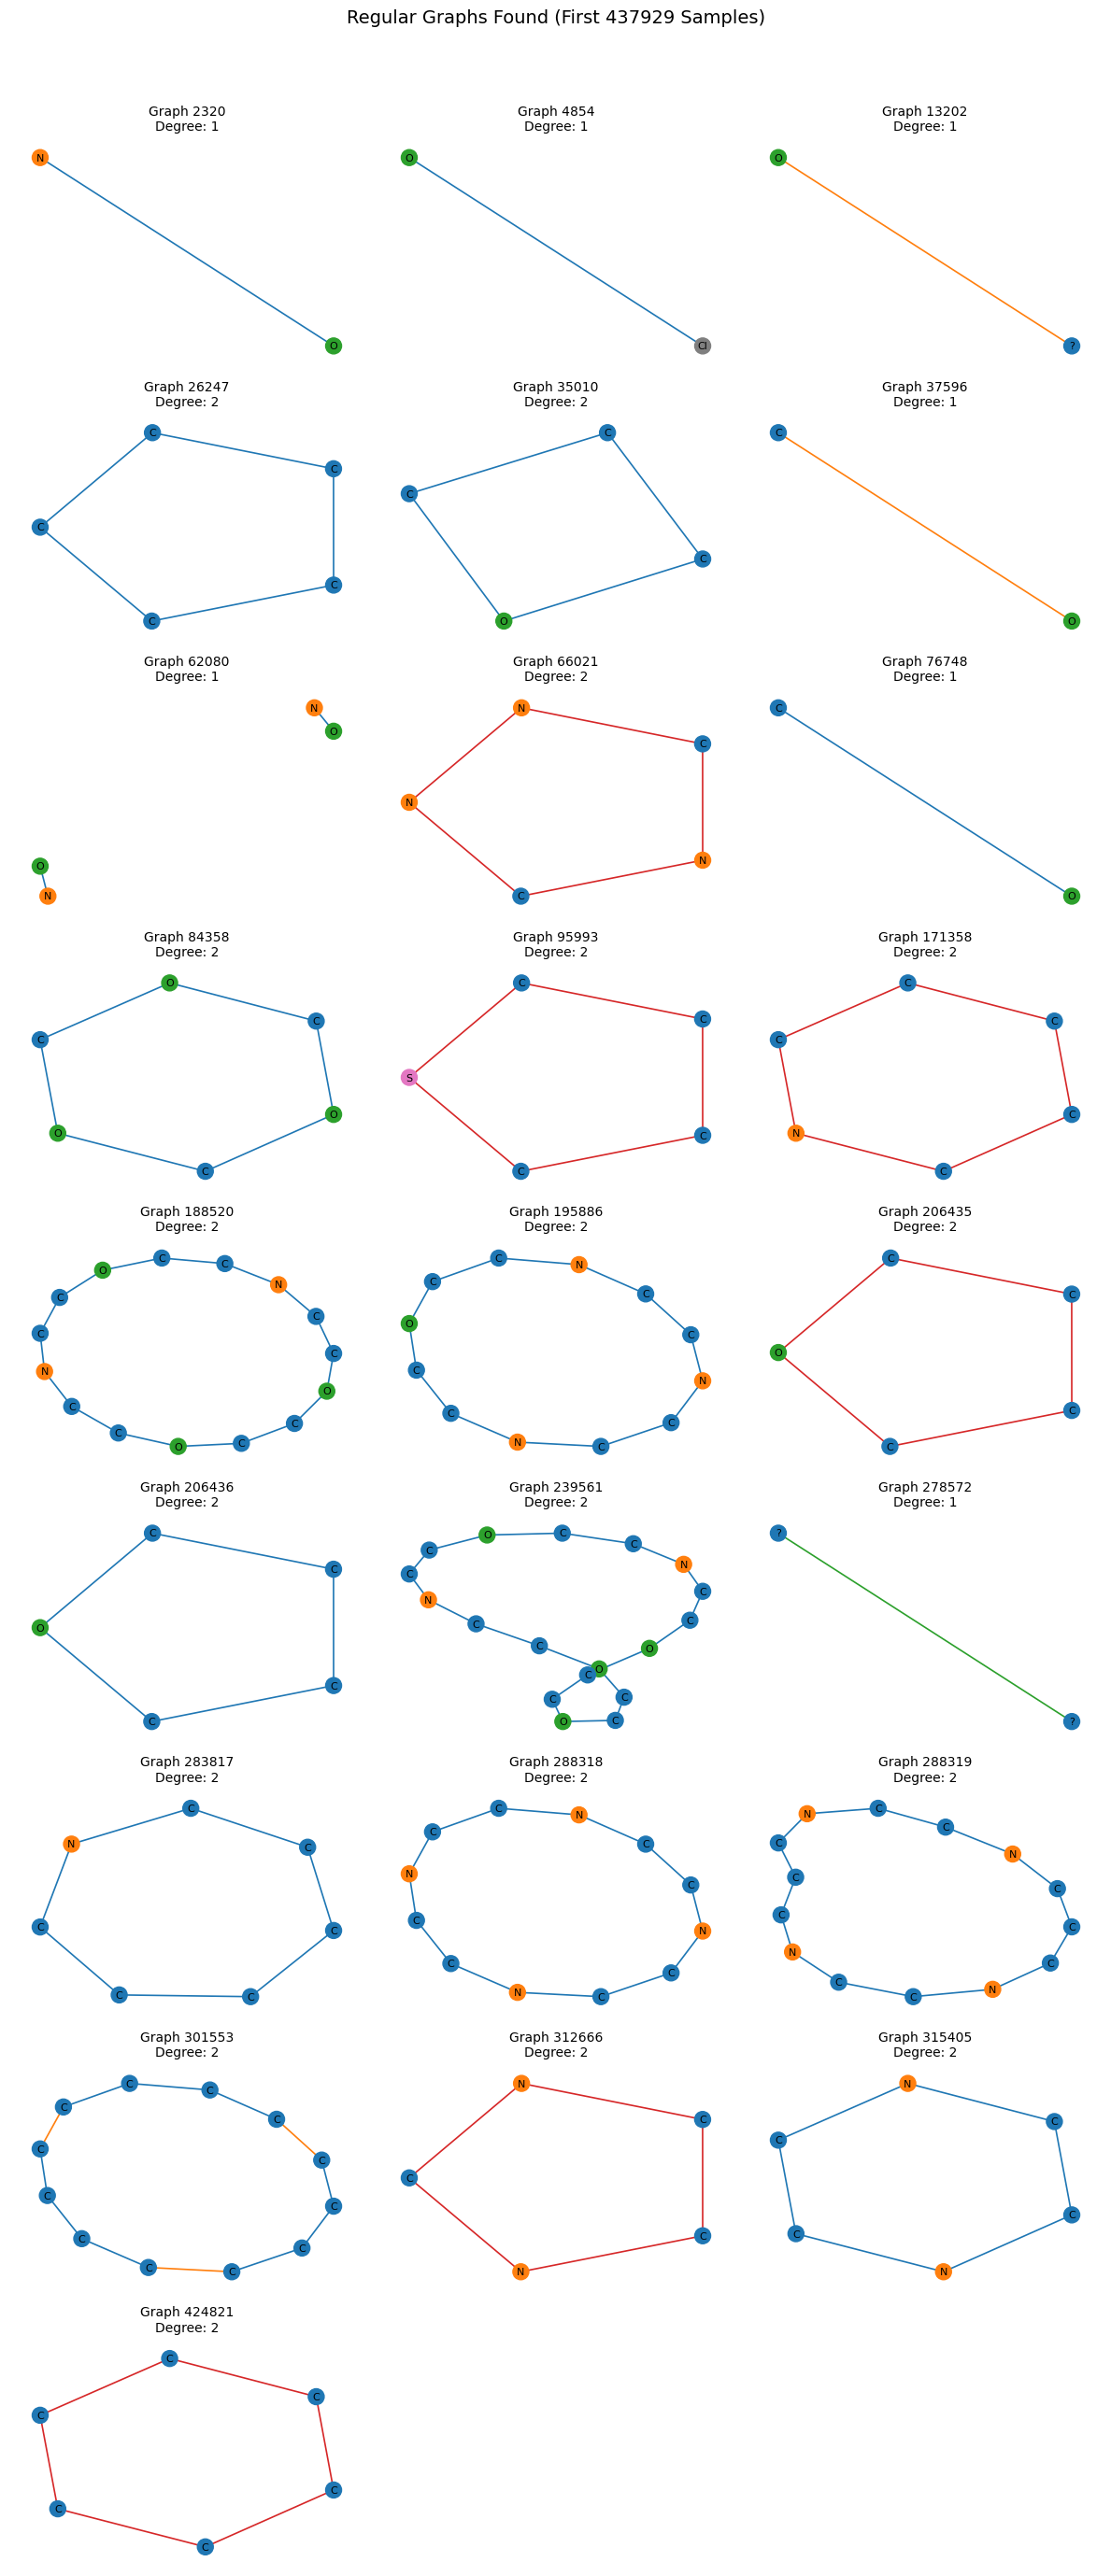

In [8]:

# ===========================================
# Regular Graph Check & Visualization
# ===========================================
def is_regular(graph):
    """Check if all nodes have the same degree"""
    undir_edge_index = to_undirected(graph.edge_index)
    if undir_edge_index.numel() == 0:  # Handle empty graphs
        return False, 0
    degrees = torch.bincount(undir_edge_index[0], minlength=graph.num_nodes)
    if not torch.all(degrees == degrees[0]):
        return False, 0
    return True, degrees[0].item()

def find_and_visualize_regular(dataset, max_check=1000):
    """Check graphs and visualize regular ones"""
    regular_graphs = []
    
    # Check graphs (limited to max_check for performance)
    for idx in range(min(len(dataset), max_check)):
        graph = dataset[idx]
        is_reg, degree = is_regular(graph)
        if is_reg:
            regular_graphs.append((idx, graph, degree))
    
    # Visualization
    if regular_graphs:
        print(f"Found {len(regular_graphs)} regular graph(s) in first {max_check} samples")
        
        # Create grid
        n = len(regular_graphs)
        cols = min(3, n)
        rows = (n + cols - 1) // cols
        fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
        axs = axs.flatten() if rows > 1 else [axs]
        
        # Plot regular graphs
        for i, (idx, graph, degree) in enumerate(regular_graphs):
            G = to_networkx(graph, to_undirected=True)
            pos = nx.spring_layout(G, seed=42, k=0.3)
            
            # Draw with chemistry styling
            nx.draw(G, pos,
                    node_color=[node_color_fn(graph)[node] for node in G.nodes()],
                    labels=node_label_fn(graph),
                    edge_color=[edge_color_fn(graph)[tuple(edge)] for edge in G.edges()],
                    with_labels=True,
                    node_size=150,
                    font_size=8,
                    width=1.2,
                    ax=axs[i])
            
            axs[i].set_title(f"Graph {idx}\nDegree: {degree}", fontsize=10)
        
        # Hide empty subplots
        for j in range(i+1, len(axs)):
            axs[j].axis('off')
            
        plt.suptitle(f"Regular Graphs Found (First {max_check} Samples)", y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No regular graphs found in first {max_check} samples")

# ===========================================
# Execution
# ===========================================
dataset = PygGraphPropPredDataset(name='ogbg-molpcba')
find_and_visualize_regular(dataset, max_check=len(dataset))  # Check first 1000 graphs